In [39]:
curr_dir = '2024-II/Aprendizaje/Tarea4/'

In [3]:
base_dir = '2024-II/Aprendizaje/Tarea4/data_tarea/'
train_dir = base_dir + 'train'
test_dir = base_dir + 'test'
# p = 'C:\Users\l-e-o\Downloads\imagedb\data_tarea\train\coast\features'
import os
print(os.path.exists(train_dir))
print(os.path.exists(test_dir))

True
True


Leer features de los archivos

In [4]:
import os
import numpy as np

def load_data(dir_path):
    all_features = {}
    all_labels = {}

    for folder in os.listdir(dir_path):
        features_path = os.path.join(dir_path, folder, 'features')
        for file in os.listdir(features_path):
            file_path = os.path.join(features_path, file)
            feautures = np.load(file_path)
            all_features[file_path] = feautures
            all_labels[file_path] = folder

    print(len(all_features))

    first_key = next(iter(all_features))
    print(all_features[first_key].shape)

    return all_features, all_labels

In [5]:
train_features, train_labels = load_data(train_dir)
# Get the first 10 items
first_10_items = dict(list(train_features.items())[:10])
test_features, test_labels = load_data(test_dir)

1500
(657, 128)
2985
(656, 128)


Crear matriz de todos los valores 

In [6]:
def create_matrix(features):
    # Crear una lista de todas las matrices de características
    list_of_matrices = list(features.values())

    # Concatenar todas las matrices en una sola matriz grande
    big_matrix = np.vstack(list_of_matrices)

    print(big_matrix.shape)  # Imprimir la forma de la matriz 2D combinada

    return big_matrix

In [7]:
train_matrix = create_matrix(train_features)
test_matrix = create_matrix(test_features)

(1032780, 128)
(2071105, 128)


Algoritmo KMeans con librería hnswlib

In [8]:
import random
# %pip install hnswlib
import hnswlib


class KMeansHNSW:

    def __init__(self, n_clusters: int, epsilon: float = 1e-4, max_iter: int = 3):
        self.n_clusters = n_clusters
        self.epsilon = epsilon
        self.max_iter = max_iter

    def build_index(self, centroids):
        self.dim = centroids.shape[1]
        self.num_elements = centroids.shape[0]
        self.p = hnswlib.Index(space='l2', dim=self.dim)
        self.p.init_index(max_elements=self.num_elements, ef_construction=200, M=16)
        self.p.add_items(centroids)

    def initialize_centroids(self, data: np.ndarray):
        indices = random.sample(range(data.shape[0]), self.n_clusters)
        self.centroids = data[indices, :]

    def fit(self, data: np.ndarray):
        self.initialize_centroids(data)
        self.build_index(self.centroids)

        # Buscar el centroide más cercano para cada punto
        labels, distances = self.p.knn_query(data, k=1)  # k=1 para encontrar el vecino más cercano
        
        # Convert labels from float to int
        labels = labels.astype(int)

        # Anadir labels a la matriz de datos
        data = np.hstack((data, labels))

        # loop hasta que converja o se alcance el número máximo de iteraciones
        for _ in range(self.max_iter):

            # recalcular los centroides
            new_centroids = np.array([data[data[:, -1] == i, :-1].mean(axis=0) for i in range(self.n_clusters)])

            # checar convergencia
            if np.linalg.norm(new_centroids - self.centroids) < self.epsilon:
                break

            self.centroids = new_centroids
            self.build_index(self.centroids)

            # Buscar el centroide más cercano para cada punto
            labels, distances = self.p.knn_query(data, k=1)  # k=1 para encontrar el vecino más cercano
            
            # Convert labels from float to int
            labels = labels.astype(int)

            # Update labels columna en la matriz de datos
            data[:, -1] = labels.ravel()
        
    def predict(self, data: np.ndarray):
        labels, distances = self.p.knn_query(data, k=1)
        return labels.ravel()

Utilizar el Método del Codo para encontrar el número de centroides (Después me di cuenta que tiene que ser 10mil)

In [9]:
import numpy as np
# %pip install matplotlib
import matplotlib.pyplot as plt


def calculate_inertia(data, kmeans_model):
    """
    Calculate the inertia (sum of squared distances of samples to their closest cluster center).
    
    Parameters:
    data (ndarray): The input data for clustering.
    kmeans_model (KMeans): The KMeans model after fitting the data.
    
    Returns:
    float: The inertia of the fitted KMeans model.
    """
    clusters = kmeans_model.predict(data)
    inertia = 0
    for i, center in enumerate(kmeans_model.centroids):
        inertia += np.sum((data[clusters == i] - center) ** 2)
    return inertia


def elbow_method(data, start_k, max_k, step=100):
    """
    Implement the elbow method to determine the optimal number of clusters for KMeans.
    
    Parameters:
    data (ndarray): The input data for clustering.
    max_k (int): The maximum number of clusters to consider.
    
    Returns:
    None: This function plots the elbow graph.
    """
    inertias = []
    for k in range(start_k, max_k + 1, step):
        print("n_clusters:", k)
        kmeans = KMeansHNSW(n_clusters=k)
        kmeans.fit(data)
        inertia = calculate_inertia(data, kmeans)
        inertias.append(inertia)
    return inertias

In [10]:
max_k = 1000
step = 100
inertias = elbow_method(train_matrix, 1, max_k=1000, step=step)

n_clusters: 1
n_clusters: 101
n_clusters: 201
n_clusters: 301
n_clusters: 401
n_clusters: 501
n_clusters: 601
n_clusters: 701
n_clusters: 801
n_clusters: 901


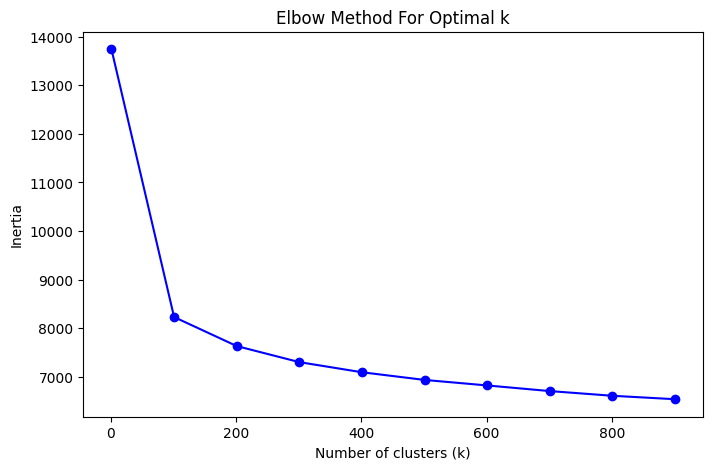

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1, step), inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [12]:
max_k = 10000
step = 9099
inertias = elbow_method(train_matrix, 901, max_k=10000, step=step)

n_clusters: 901
n_clusters: 10000


/tmp/ipykernel_1145539/2079289553.py:41: RuntimeWarning: Mean of empty slice.
  new_centroids = np.array([data[data[:, -1] == i, :-1].mean(axis=0) for i in range(self.n_clusters)])
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [31]:
print(inertias)

[6542.4006497026885, nan]


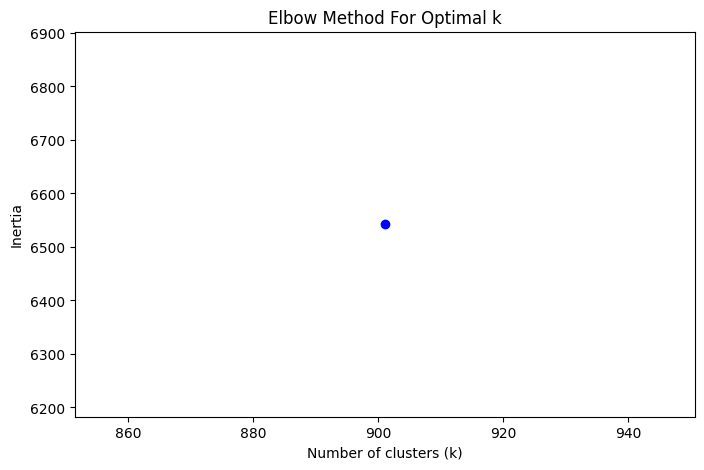

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(range(901, max_k + 2, step), inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

Agrupar los vectores de características con kmeans con k=10000

In [14]:
kmeans = KMeansHNSW(n_clusters=10000)
kmeans.fit(train_matrix)

/tmp/ipykernel_1145539/2079289553.py:41: RuntimeWarning: Mean of empty slice.
  new_centroids = np.array([data[data[:, -1] == i, :-1].mean(axis=0) for i in range(self.n_clusters)])


Calcular la representación de bolsa de palabras para cada imagen

In [15]:
def get_histograms(kmeans_, all_features):
    histograms = []

    for image_path in all_features.keys():
        features = all_features[image_path]
        labels = kmeans_.predict(features)
        histogram = np.zeros(kmeans_.n_clusters)
        for label in labels:
            histogram[label] += 1
        histograms.append(histogram)

    # Convertir la lista de histogramas en una matriz
    histograms_matrix = np.vstack(histograms).astype(int)

    return histograms_matrix

In [16]:
train_histograms = get_histograms(kmeans, train_features)
test_histograms = get_histograms(kmeans, test_features)

In [17]:
y_train = np.array(list(train_labels.values()))
# Contar cuántas veces aparece cada etiqueta en el conjunto de entrenamiento
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
y_test = np.array(list(test_labels.values()))

{'bedroom': 100, 'coast': 100, 'forest': 100, 'highway': 100, 'industrial': 100, 'insidecity': 100, 'kitchen': 100, 'livingroom': 100, 'mountain': 100, 'office': 100, 'opencountry': 100, 'store': 100, 'street': 100, 'suburb': 100, 'tallbuilding': 100}


In [18]:
# Define the mapping
label_mapping = {'bedroom': 0, 'coast': 1, 'forest': 2, 'highway': 3, 'industrial': 4, 'insidecity': 5, 'kitchen': 6, 'livingroom': 7, 'mountain': 8, 'office': 9, 'opencountry': 10, 'store': 11, 'street': 12, 'suburb': 13, 'tallbuilding': 14}

# Manually apply the mapping
y_train = np.array([label_mapping[label] for label in y_train])
y_test = np.array([label_mapping[label] for label in y_test])

### Entrenar modelos con vectores de características originales

Entrenar un modelo de gradient boosted trees

In [19]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [61]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def train_xgboost(train_histograms_, y_train_, test_histograms_, y_test_, savename):
    # Crear el DMatrix para XGBoost
    dtrain = xgb.DMatrix(train_histograms_, label=y_train_)
    dtest = xgb.DMatrix(test_histograms_, label=y_test_)

    # Model parameters
    params = {
        'max_depth': 3,
        'eta': 0.1,
        'objective': 'multi:softmax',  # Use 'multi:softmax' for direct class output
        'num_class': 15,  # Number of classes
        'eval_metric': 'mlogloss',  # Multiclass logloss
        'tree_method': 'hist',  # Use histogram-based algorithm
        'device': 'cuda'  # Use GPU
    }

    # Entrenar el modelo
    num_round = 500

    evals = [(dtrain, 'train'), (dtest, 'eval')]
    bst = xgb.train(params, dtrain, num_round, evals, early_stopping_rounds=25)

    # Save the model
    model_path = f"{curr_dir}{savename}.json"
    bst.save_model(model_path)
    print(f"Model saved to {model_path}")

    # Hacer predicciones y evaluar el modelo
    y_pred = bst.predict(dtest)
    accuracy = accuracy_score(y_test_, y_pred)
    
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_test_, y_pred)

    print(f'Accuracy: {accuracy:.2f}')
    print('Confusion Matrix:')
    print(conf_matrix)


In [21]:
def load_xgboost_model(model_filename, test_histograms_, y_test_):
    # Load the model
    bst = xgb.Booster()
    bst.load_model(model_filename)
    print(f"Model loaded from {model_filename}")

    # Crear el DMatrix para XGBoost
    dtest = xgb.DMatrix(test_histograms_, label=y_test_)

    # Hacer predicciones y evaluar el modelo
    y_pred = bst.predict(dtest)
    accuracy = accuracy_score(y_test_, y_pred)
    
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_test_, y_pred)

    print(f'Accuracy: {accuracy:.2f}')
    print('Confusion Matrix:')
    print(conf_matrix)

In [62]:
train_xgboost(train_histograms, y_train, test_histograms, y_test, 'xgboost_model')

/home/leon/.local/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:2.59842	eval-mlogloss:2.65534
[1]	train-mlogloss:2.50373	eval-mlogloss:2.61085
[2]	train-mlogloss:2.41979	eval-mlogloss:2.57287
[3]	train-mlogloss:2.34317	eval-mlogloss:2.54013
[4]	train-mlogloss:2.26828	eval-mlogloss:2.50916
[5]	train-mlogloss:2.19923	eval-mlogloss:2.47743
[6]	train-mlogloss:2.13732	eval-mlogloss:2.44835
[7]	train-mlogloss:2.07517	eval-mlogloss:2.42372
[8]	train-mlogloss:2.01899	eval-mlogloss:2.40131
[9]	train-mlogloss:1.96479	eval-mlogloss:2.37908
[10]	train-mlogloss:1.91380	eval-mlogloss:2.36087
[11]	train-mlogloss:1.86385	eval-mlogloss:2.33968
[12]	train-mlogloss:1.81598	eval-mlogloss:2.32178
[13]	train-mlogloss:1.77192	eval-mlogloss:2.30587
[14]	train-mlogloss:1.72966	eval-mlogloss:2.29229
[15]	train-mlogloss:1.68865	eval-mlogloss:2.27809
[16]	train-mlogloss:1.64759	eval-mlogloss:2.26311
[17]	train-mlogloss:1.60869	eval-mlogloss:2.24923
[18]	train-mlogloss:1.57200	eval-mlogloss:2.23439
[19]	train-mlogloss:1.53547	eval-mlogloss:2.22293
[20]	train

Entrenar un modelo de Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
import joblib

def train_random_forest(train_histograms_, y_train_, test_histograms_, y_test_, savename):
    # Create and train the Random Forest model
    rf = RandomForestClassifier(n_estimators=5000, max_depth=None, random_state=42)
    rf.fit(train_histograms_, y_train_)

    # Save the model with timestamp
    model_path = f"{curr_dir}{savename}.joblib"
    joblib.dump(rf, model_path)
    print(f"Model saved to {model_path}")

    # Make predictions and evaluate the model
    y_pred = rf.predict(test_histograms_)
    accuracy = accuracy_score(y_test_, y_pred)

    # Calculate and print the confusion matrix
    conf_matrix = confusion_matrix(y_test_, y_pred)

    print(f'Accuracy: {accuracy:.2f}')
    print('Confusion Matrix:')
    print(conf_matrix)

In [24]:
def load_random_forest_model(model_filename, test_histograms_, y_test_):
    # Load the model
    rf = joblib.load(model_filename)
    print(f"Model loaded from {model_filename}")

    # Make predictions and evaluate the model
    y_pred = rf.predict(test_histograms_)
    accuracy = accuracy_score(y_test_, y_pred)
    
    # Calculate and print the confusion matrix
    conf_matrix = confusion_matrix(y_test_, y_pred)

    print(f'Accuracy: {accuracy:.2f}')
    print('Confusion Matrix:')
    print(conf_matrix)

In [70]:
train_random_forest(train_histograms, y_train, test_histograms, y_test, savename='random_forest_model')

Model saved to 2024-II/Aprendizaje/Tarea4/random_forest_model.joblib
Accuracy: 0.45
Confusion Matrix:
[[ 13  15   7   2   0   2  39  17   1  12   2   0   1   2   3]
 [  2 220   9  14   0   0   0   1   2   0  10   0   0   2   0]
 [  0   2 220   0   0   0   0   0   3   0   1   0   0   2   0]
 [  3  54   8  73   0   2   3   2   0   1   5   0   0   6   3]
 [ 10  31   9   3   6  22  44  14   4  14   6  14   7  21   6]
 [  3   6   3   3   0 104  34   1   0  18   1  14   5   3  13]
 [  2   3   0   0   0   5  73   4   0  22   0   1   0   0   0]
 [ 14   4   0   0   1   5  32  64   1  43   0   4   2  15   4]
 [  5  43  66  16   0   0   4   1  77   0  32   0   1  29   0]
 [  2   0   0   0   0   2  30   3   0  78   0   0   0   0   0]
 [  0  85  88  24   0   0   2   2  16   0  81   0   0  11   1]
 [  2   3  41   2   1  23  29   5   0  17   3  62   1  20   6]
 [  0   9  15  11   4  23  20   3   8   7  20  13  29  13  17]
 [  0   0   7   2   0   2   1   2   1   8   0   0   0 117   1]
 [  1  28   7   

Entrenar un modelo de SVM

In [88]:
from sklearn.svm import SVC

def train_svm(train_histograms_, y_train_, test_histograms_, y_test_, savename):
    # Create and train the SVM model
    svm = SVC(kernel='rbf', C=3, random_state=42)     # 0.51 accuracy
    svm.fit(train_histograms_, y_train_)

    # Save the model
    model_path = f"{curr_dir}{savename}.joblib"
    joblib.dump(svm, model_path)
    print(f"Model saved to {model_path}")

    # Make predictions and evaluate the model
    y_pred = svm.predict(test_histograms_)
    accuracy = accuracy_score(y_test_, y_pred)

    # Calculate and print the confusion matrix
    conf_matrix = confusion_matrix(y_test_, y_pred)

    print(f'Accuracy: {accuracy:.2f}')
    print('Confusion Matrix:')
    print(conf_matrix)

In [27]:
def load_svm_model(model_filename, test_histograms_, y_test_):
    # Load the model
    svm = joblib.load(model_filename)
    print(f"Model loaded from {model_filename}")

    # Make predictions and evaluate the model
    y_pred = svm.predict(test_histograms_)
    accuracy = accuracy_score(y_test_, y_pred)
    
    # Calculate and print the confusion matrix
    conf_matrix = confusion_matrix(y_test_, y_pred)

    print(f'Accuracy: {accuracy:.2f}')
    print('Confusion Matrix:')
    print(conf_matrix)

In [89]:
train_svm(train_histograms, y_train, test_histograms, y_test, savename='svm_model')

Model saved to 2024-II/Aprendizaje/Tarea4/svm_model.joblib
Accuracy: 0.51
Confusion Matrix:
[[ 37   6   0   5   5   3  22  14   6   3   1   3   3   4   4]
 [  4 182   6  28   1   0   1   0  11   0  26   0   0   0   1]
 [  0   0 190   0   0   0   0   0  13   0  19   1   1   4   0]
 [  6  24   2  90   4   3   1   2   1   0   8   1   9   6   3]
 [ 19   6   2   8  45  16  13  26   9   8   7  14  24   7   7]
 [  9   3   0   2  13 105  13   4   2   5   2  25  11   4  10]
 [ 12   2   0   0   6   7  54   9   0  18   0   1   1   0   0]
 [ 36   1   0   1   4   3  13  78   2  22   0  10   5  11   3]
 [ 11  21  19  13   3   0   0   3 125   1  43   3   9  22   1]
 [  7   0   0   0   1   4  27   7   0  66   0   2   1   0   0]
 [  2  53  39  27   0   0   0   0  48   0 125   1   6   8   1]
 [ 10   1   6   2  13  15  10  10   5   9   4 106   8   9   7]
 [  6   1   3   5  17  15   2   5  18   5  13  17  75   5   5]
 [  0   0   3   2   2   3   0   6   6   2   0   4   1 111   1]
 [  5   6   1   5  14  28 

### Entrenar modelos reduciendo las dimensiones de los vectores de características

Utilzar un autoencoder para reducir la dimensionalidad

In [90]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the autoencoder model
input_dim = train_histograms.shape[1]
encoding_dim = 1000

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(train_histograms, train_histograms, epochs=50, batch_size=256, shuffle=True, validation_data=(test_histograms, test_histograms))

# Use the encoder to reduce the dimensionality
encoder_model = Model(inputs=input_layer, outputs=encoder)
train_histograms_encoded = encoder_model.predict(train_histograms)
test_histograms_encoded = encoder_model.predict(test_histograms)

print("Original shape:", train_histograms.shape)
print("Reduced shape:", train_histograms_encoded.shape)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 843ms/step - loss: 0.2963 - val_loss: 0.1568
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - loss: 0.1725 - val_loss: 0.1568
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - loss: 0.1611 - val_loss: 0.1566
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - loss: 0.1646 - val_loss: 0.1564
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - loss: 0.1668 - val_loss: 0.1563
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - loss: 0.1646 - val_loss: 0.1560
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - loss: 0.1588 - val_loss: 0.1558
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - loss: 0.1675 - val_loss: 0.1556
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - loss: 0.1720 - val_loss: 0.1555
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - loss: 0.1698 - val_loss: 0.1553
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - loss: 0.1744 - val_loss: 0.1552
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - loss: 0.1722 - val_lo

Utilizar el PCA para reducción de dimensionalidad

In [91]:
import numpy as np
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA().fit(train_histograms)

# Plot the cumulative variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f'Number of components to explain 95% variance: {n_components}')


Number of components to explain 95% variance: 1087


In [92]:
# Apply PCA to reduce dimensionality to 50 components
pca = PCA(n_components=n_components)
train_histograms_pca = pca.fit_transform(train_histograms)
test_histograms_pca = pca.transform(test_histograms)

print("Original shape:", train_histograms.shape)
print("Reduced shape:", train_histograms_pca.shape)


Original shape: (1500, 10000)
Reduced shape: (1500, 1087)


Entrenar los modelos con los vectores reducidos por el autoencoder

In [94]:
train_xgboost(train_histograms_encoded, y_train, test_histograms_encoded, y_test, 'xgboost_model_encoded')
train_random_forest(train_histograms_encoded, y_train, test_histograms_encoded, y_test, savename='random_forest_model_encoded')
train_svm(train_histograms_encoded, y_train, test_histograms_encoded, y_test, savename='svm_model_encoded')

[0]	train-mlogloss:2.56611	eval-mlogloss:2.64579
[1]	train-mlogloss:2.44683	eval-mlogloss:2.59118
[2]	train-mlogloss:2.34196	eval-mlogloss:2.54653
[3]	train-mlogloss:2.24743	eval-mlogloss:2.50367


/home/leon/.local/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[4]	train-mlogloss:2.16003	eval-mlogloss:2.46670
[5]	train-mlogloss:2.08103	eval-mlogloss:2.43300
[6]	train-mlogloss:2.00808	eval-mlogloss:2.39947
[7]	train-mlogloss:1.94218	eval-mlogloss:2.37002
[8]	train-mlogloss:1.87485	eval-mlogloss:2.34312
[9]	train-mlogloss:1.81488	eval-mlogloss:2.31742
[10]	train-mlogloss:1.75747	eval-mlogloss:2.29325
[11]	train-mlogloss:1.70206	eval-mlogloss:2.27085
[12]	train-mlogloss:1.64939	eval-mlogloss:2.24892
[13]	train-mlogloss:1.59952	eval-mlogloss:2.22799
[14]	train-mlogloss:1.55116	eval-mlogloss:2.20922
[15]	train-mlogloss:1.50696	eval-mlogloss:2.19264
[16]	train-mlogloss:1.46252	eval-mlogloss:2.17448
[17]	train-mlogloss:1.42191	eval-mlogloss:2.15701
[18]	train-mlogloss:1.38352	eval-mlogloss:2.14113
[19]	train-mlogloss:1.34672	eval-mlogloss:2.12576
[20]	train-mlogloss:1.31046	eval-mlogloss:2.11327
[21]	train-mlogloss:1.27639	eval-mlogloss:2.09946
[22]	train-mlogloss:1.24215	eval-mlogloss:2.08556
[23]	train-mlogloss:1.20924	eval-mlogloss:2.07216
[24]	t

Entrenar los modelos con los vectores reducidos por el PCA

In [109]:
train_xgboost(train_histograms_pca, y_train, test_histograms_pca, y_test, savename='xgboost_model_pca')
train_random_forest(train_histograms_pca, y_train, test_histograms_pca, y_test, savename='random_forest_model_pca')
train_svm(train_histograms_pca, y_train, test_histograms_pca, y_test, savename='svm_model_pca')

[0]	train-mlogloss:2.56370	eval-mlogloss:2.63136
[1]	train-mlogloss:2.44486	eval-mlogloss:2.57427
[2]	train-mlogloss:2.34441	eval-mlogloss:2.52432
[3]	train-mlogloss:2.25472	eval-mlogloss:2.48239


/home/leon/.local/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[4]	train-mlogloss:2.17356	eval-mlogloss:2.44531
[5]	train-mlogloss:2.09930	eval-mlogloss:2.41344
[6]	train-mlogloss:2.02727	eval-mlogloss:2.38218
[7]	train-mlogloss:1.96469	eval-mlogloss:2.35273
[8]	train-mlogloss:1.90372	eval-mlogloss:2.32821
[9]	train-mlogloss:1.84734	eval-mlogloss:2.30581
[10]	train-mlogloss:1.79385	eval-mlogloss:2.28692
[11]	train-mlogloss:1.74127	eval-mlogloss:2.26994
[12]	train-mlogloss:1.69136	eval-mlogloss:2.25555
[13]	train-mlogloss:1.64399	eval-mlogloss:2.23949
[14]	train-mlogloss:1.59631	eval-mlogloss:2.22464
[15]	train-mlogloss:1.55312	eval-mlogloss:2.21102
[16]	train-mlogloss:1.51053	eval-mlogloss:2.19819
[17]	train-mlogloss:1.47122	eval-mlogloss:2.18416
[18]	train-mlogloss:1.43240	eval-mlogloss:2.17427
[19]	train-mlogloss:1.39666	eval-mlogloss:2.16108
[20]	train-mlogloss:1.35934	eval-mlogloss:2.15090
[21]	train-mlogloss:1.32645	eval-mlogloss:2.14125
[22]	train-mlogloss:1.29144	eval-mlogloss:2.13206
[23]	train-mlogloss:1.25904	eval-mlogloss:2.12325
[24]	t

### Entrenar modelos reduciendo las bolsas de características

In [95]:
feature_presence = (train_histograms > 0).astype(int)
print("Feature presence matrix shape:", feature_presence.shape)

feature_presence_counts = feature_presence.sum(axis=0)
print("Feature presence counts:", feature_presence_counts)

Feature presence matrix shape: (1500, 10000)
Feature presence counts: [ 71  44  29 ...  72 142  86]


In [120]:
# Definir un umbral para eliminar características comunes (por ejemplo, presentes en más del 90% de las bolsas)
threshold = 0.05 * train_histograms.shape[0]
print("Threshold:", threshold)

# Identificar las características comunes
common_features = np.where(feature_presence_counts > threshold)[0]
print("Common features to remove:", common_features)
print("Number of common features:", len(common_features))

# Eliminar las características comunes de todas las bolsas de características
def remove_common_features(features, common_features):
    return np.delete(features, common_features, axis=1)

reduced_bag_of_features_train = remove_common_features(train_histograms, common_features)

# use same feautures for test
reduced_bag_of_features_test = remove_common_features(test_histograms, common_features)

Threshold: 75.0
Common features to remove: [   3    4    5 ... 9994 9998 9999]
Number of common features: 3398


Entrenar modelos con bolsa de características reducida

In [121]:
train_xgboost(reduced_bag_of_features_train, y_train, reduced_bag_of_features_test, y_test, savename='xgboost_model_rbc')

[0]	train-mlogloss:2.66168	eval-mlogloss:2.68917
[1]	train-mlogloss:2.61729	eval-mlogloss:2.67258


/home/leon/.local/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[2]	train-mlogloss:2.57607	eval-mlogloss:2.65894
[3]	train-mlogloss:2.53873	eval-mlogloss:2.64707
[4]	train-mlogloss:2.50281	eval-mlogloss:2.63421
[5]	train-mlogloss:2.46712	eval-mlogloss:2.62449
[6]	train-mlogloss:2.43372	eval-mlogloss:2.61559
[7]	train-mlogloss:2.40187	eval-mlogloss:2.60634
[8]	train-mlogloss:2.37134	eval-mlogloss:2.59823
[9]	train-mlogloss:2.34120	eval-mlogloss:2.59101
[10]	train-mlogloss:2.31227	eval-mlogloss:2.58324
[11]	train-mlogloss:2.28340	eval-mlogloss:2.57550
[12]	train-mlogloss:2.25564	eval-mlogloss:2.56904
[13]	train-mlogloss:2.22847	eval-mlogloss:2.56275
[14]	train-mlogloss:2.20271	eval-mlogloss:2.55771
[15]	train-mlogloss:2.17680	eval-mlogloss:2.55192
[16]	train-mlogloss:2.15197	eval-mlogloss:2.54563
[17]	train-mlogloss:2.12687	eval-mlogloss:2.53991
[18]	train-mlogloss:2.10309	eval-mlogloss:2.53504
[19]	train-mlogloss:2.07827	eval-mlogloss:2.52917
[20]	train-mlogloss:2.05500	eval-mlogloss:2.52231
[21]	train-mlogloss:2.03266	eval-mlogloss:2.51705
[22]	tra

In [123]:
train_random_forest(reduced_bag_of_features_train, y_train, reduced_bag_of_features_test, y_test, savename='random_forest_model_rbc')

Model saved to 2024-II/Aprendizaje/Tarea4/random_forest_model_rbc.joblib
Accuracy: 0.32
Confusion Matrix:
[[ 15  33   7   4   0   5  13   2   0  21   3   0   2   1  10]
 [  1 226   9   8   0   0   0   0   1   0   7   0   0   0   8]
 [  0   2 213   1   0   0   0   0   1   0  10   0   0   0   1]
 [  1  84   5  43   0   1   1   1   0   2  11   0   1   0  10]
 [  7  66  21   5   6  27  19   3   2  19   5   2   9   1  19]
 [  3  17   8   5   0  61  14   0   1  56   6   2   4   1  30]
 [  5  23   2   0   2   8  30   1   0  35   2   0   0   0   2]
 [ 20  24   1   5   3  12  31  18   1  63   1   1   1   0   8]
 [  1  88  71  16   0   0   1   0  35   1  43   0   4   2  12]
 [  3   9   0   1   0   7  29   2   0  64   0   0   0   0   0]
 [  0 129  94  21   0   0   0   0  11   0  44   0   0   0  11]
 [  8  20  61   3   2  34  16   3   6  23   4  12   2   0  21]
 [  3  28  34  17   5  16  11   0   5   9  17   2  12   1  32]
 [  1   4  45   3   2   7   7   2   7  22   5   0   0  25  11]
 [  0  33  1

In [124]:
train_svm(reduced_bag_of_features_train, y_train, reduced_bag_of_features_test, y_test, savename='svm_model_rbc')

Model saved to 2024-II/Aprendizaje/Tarea4/svm_model_rbc.joblib
Accuracy: 0.40
Confusion Matrix:
[[ 26  12   0   2   7   2  19  15   4   0   0   8   5  12   4]
 [  6 158   3  29   2   0   0   5  14   0  32   1   5   5   0]
 [  0   3 167   5   0   0   0   0  11   0  17   4   0  21   0]
 [  2  33   1  64   4   0   2   3  11   0  18   0   7  13   2]
 [ 12  16   3  10  43   7  21  18   2   7   8  22  20  20   2]
 [  4   2   0   4  18  55  33   8   3   8   3  33   8  17  12]
 [  9   4   0   0  10   3  52   5   0  13   2   7   2   1   2]
 [ 23   1   0   2  10   3  18  62   1  11   0  16   2  35   5]
 [  4  15  22  25   5   0   0   4  82   0  50   4  12  51   0]
 [  7   2   0   0   4   6  26  14   0  45   0   7   0   4   0]
 [  3  63  37  25   1   1   0   3  52   0  89   3  13  19   1]
 [  5   2   2   1  20  19   9   8   6   4   2  91  12  32   2]
 [  4   3   0   9  31  11   8   7   7   0   6  26  58  14   8]
 [  1   0   2   0   3   1   0   4   6   2   0   3   2 113   4]
 [  5  18   3  10  21 